In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display
import io

# Check for GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Upload Targeted Station CSV
target_upload = widgets.FileUpload(accept='.csv', multiple=False)
display(widgets.Label(value="Upload Targeted Station CSV"), target_upload)

# Upload Multiple Selected Stations CSVs
selected_upload = widgets.FileUpload(accept='.csv', multiple=True)
display(widgets.Label(value="Upload Selected Stations CSVs"), selected_upload)

# Wait for user to upload files
while not target_upload.value or not selected_upload.value:
    pass  # Wait until files are uploaded

# Read targeted station CSV
target_df = pd.read_csv(io.BytesIO(list(target_upload.value.values())[0]['content']))

# Read and merge multiple selected stations CSVs
input_dfs = [pd.read_csv(io.BytesIO(file['content'])) for file in selected_upload.value.values()]
input_df = pd.concat(input_dfs, ignore_index=True)  # Combine into one DataFrame

# Sort data by date
target_df = target_df.sort_values(by="Date")
input_df = input_df.sort_values(by="Date")

# Normalize features
scaler = MinMaxScaler()
target_df.iloc[:, 1:] = scaler.fit_transform(target_df.iloc[:, 1:])  # Assuming features start from column 1
input_df.iloc[:, 1:] = scaler.transform(input_df.iloc[:, 1:])

# Convert to NumPy arrays
X = input_df.iloc[:, 1:].values  # Input features
Y = target_df.iloc[:, 1:].values  # Output features

# Function to create sequences
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Predicting next 7 days
X_train, Y_train = create_sequences(X, Y, time_steps)

# Define Optimized RNN Model
model = Sequential([
    LSTM(20, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),  # Reduced from 50 to 20
    LSTM(20, activation='relu'),  # Reduced from 50 to 20
    Dense(Y_train.shape[1])  # Output layer for multi-feature prediction
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model (Optimized Training)
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)  # Reduced epochs from 50 to 10

# Predict next 7 days
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take the last sequence
predicted_weather = model.predict(test_input)

# Convert predictions back to original scale
real_predictions = scaler.inverse_transform(predicted_weather)

# Display Predictions
print("Predicted Weather for Next 7 Days (Scaled Values):")
print(predicted_weather)

print("Predicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

In [1]:
# Install required libraries (if not already installed)
!pip install tensorflow pandas numpy scikit-learn

# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import os

# Check for GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Upload Targeted Station CSV (use file dialog in Jupyter)
from tkinter import Tk
from tkinter.filedialog import askopenfilename

print("Upload Targeted Station CSV")
Tk().withdraw()  # Prevents the root window from appearing
target_filename = askopenfilename(title="Select Targeted Station CSV")
target_df = pd.read_csv(target_filename)

# Upload Multiple Selected Stations CSVs
print("Upload Selected Stations CSVs")
selected_filenames = askopenfilename(title="Select Selected Stations CSV", multiple=True)
selected_dfs = [pd.read_csv(filename) for filename in selected_filenames]

# Sort data by date (assuming 'Date' column exists)
if 'Date' in target_df.columns:
    target_df = target_df.sort_values(by="Date")
else:
    target_df = target_df.sort_values(by="DATE")  # Try 'DATE' if 'Date' is not found

# Normalize features (excluding Date and TIME(UTC) columns)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# 🔸 Select only numerical columns for scaling
numerical_cols_input = target_df.select_dtypes(include=np.number).columns[1:]  # Exclude 'DATE' or similar
numerical_cols_target = target_df.select_dtypes(include=np.number).columns[1:]  # Exclude 'DATE' or similar

X = scaler_x.fit_transform(target_df[numerical_cols_input].values)  # Input features
Y = scaler_y.fit_transform(target_df[numerical_cols_target].values)  # Output features

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    num_sequences = min(len(X), len(Y)) - time_steps 
    for i in range(num_sequences):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Predicting next 7 days
X_train, Y_train = create_sequences(X, Y, time_steps)

# Define Optimized RNN Model
model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(Y_train.shape[1])  # Output layer for multi-feature prediction
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

# Predict next 7 days
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take the last sequence
predicted_weather = model.predict(test_input)

# Convert predictions back to original scale
real_predictions = scaler_y.inverse_transform(predicted_weather)

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Scaled Values):")
print(predicted_weather)

print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Upload Targeted Station CSV


2025-02-19 11:04:59.001 Python[2402:18130] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-19 11:04:59.391 Python[2402:18130] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


Upload Selected Stations CSVs


/Users/rohitlabade/Desktop/IMD-Project/.venv/lib/python3.12/site-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/rohitlabade/Desktop/IMD-Project/.venv/lib/python3.12/site-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/Users/rohitlabade/Desktop/IMD-Project/.venv/lib/python3.12/site-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/rohitlabade/Desktop/IMD-Project/.venv/lib/python3.12/site-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
2025-02-19 11:05:11.961482: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-19 11:05:11.961655: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-1

Epoch 1/10


2025-02-19 11:05:12.678840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - loss: nan
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: nan
Epoch 3/10
18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: nan

: 

In [2]:
# Check for NaN values in the dataset
print("Target Data NaN values:", target_df.isna().sum())
print("Input Data NaN values:", input_df.isna().sum())

# Handle NaN values (e.g., fill with mean or drop rows)
target_df = target_df.fillna(target_df.mean())
input_df = input_df.fillna(input_df.mean())

Target Data NaN values: DATE                         0
TIME(UTC)                    0
RAIN_HOURLY(mm)           2771
RAIN_DAILY(mm)               0
TEMP(C)                      0
TEMP_MIN(C)                  0
TEMP_MAX(C)                  0
TEMP_MIN_MAX_DAY(C)       2709
DEW_POINT(C)              2771
RH(%)                        0
RH_MIN_MAX_DAY(%)         2771
WIND_DIR_10m(deg)         2771
WIND_SPEED_10m(kt)        2771
WIND_MAX/GUST_10m(kt)     2771
WIND_DIR_3m(deg)          2771
WIND_SPEED_3m(kt)         2771
WIND_MAX/GUST_3m(kt)      2771
SLP(hPa)                  2771
MSLP(hPa)                 2771
SUNSHINE(HH:MM)           2771
SOIL_TEMP_10cm(C)         2771
SOIL_MOIS_10cm(m3/m3)     2771
SOIL_TEMP_30cm(C)         2771
SOIL_MOIS_30cm(m3/m3)     2771
SOIL_TEMP_70cm(C)         2771
SOIL_MOIS_70cm(m3/m3)     2771
SOIL_TEMP_100cm(C)        2771
SOIL_MOIS_100cm(m3/m3)    2771
GLOBAL_RADIATION(v/m2)       0
PAR(micro-mole/m2s)       2771
Unnamed: 30               2771
dtype: int64


NameError: name 'input_df' is not defined

In [3]:
print("X_train Shape:", X_train.shape)

X_train Shape: (2764, 7, 28)


In [4]:
print("X_train Sample:", X_train[0])
print("Y_train Sample:", Y_train[0])

X_train Sample: [[0.         0.215      0.2345679  0.55900621        nan        nan
  0.67058824        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [0.         0.395      0.49382716 0.60869565        nan        nan
  0.68235294        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [0.         0.395      0.49382716 0.60869565        nan        nan
  0.69411765        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.                nan        nan]
 [0.         0.4        0.5

In [5]:
# Check for NaN values in the dataset
print("Target Data NaN values:", target_df.isna().sum())
print("Input Data NaN values:", input_df.isna().sum())

# Handle NaN values (e.g., fill with mean or drop rows)
target_df = target_df.fillna(target_df.mean())
input_df = input_df.fillna(input_df.mean())

# Normalize features (excluding Date and TIME(UTC) columns)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Select only numerical columns for scaling
numerical_cols_input = target_df.select_dtypes(include=np.number).columns[1:]  # Exclude 'DATE' or similar
numerical_cols_target = target_df.select_dtypes(include=np.number).columns[1:]  # Exclude 'DATE' or similar

X = scaler_x.fit_transform(target_df[numerical_cols_input].values)  # Input features
Y = scaler_y.fit_transform(target_df[numerical_cols_target].values)  # Output features

# Check the scaling output
print("Sample X after scaling:", X[0])
print("Sample Y after scaling:", Y[0])

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    num_sequences = min(len(X), len(Y)) - time_steps 
    for i in range(num_sequences):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Predicting next 7 days
X_train, Y_train = create_sequences(X, Y, time_steps)

# Check the shape of X_train and Y_train
print("X_train Shape:", X_train.shape)
print("Y_train Shape:", Y_train.shape)

# Define Optimized RNN Model
model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(Y_train.shape[1])  # Output layer for multi-feature prediction
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

# Predict next 7 days
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take the last sequence
predicted_weather = model.predict(test_input)

# Convert predictions back to original scale
real_predictions = scaler_y.inverse_transform(predicted_weather)

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Scaled Values):")
print(predicted_weather)

print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

Target Data NaN values: DATE                         0
TIME(UTC)                    0
RAIN_HOURLY(mm)           2771
RAIN_DAILY(mm)               0
TEMP(C)                      0
TEMP_MIN(C)                  0
TEMP_MAX(C)                  0
TEMP_MIN_MAX_DAY(C)       2709
DEW_POINT(C)              2771
RH(%)                        0
RH_MIN_MAX_DAY(%)         2771
WIND_DIR_10m(deg)         2771
WIND_SPEED_10m(kt)        2771
WIND_MAX/GUST_10m(kt)     2771
WIND_DIR_3m(deg)          2771
WIND_SPEED_3m(kt)         2771
WIND_MAX/GUST_3m(kt)      2771
SLP(hPa)                  2771
MSLP(hPa)                 2771
SUNSHINE(HH:MM)           2771
SOIL_TEMP_10cm(C)         2771
SOIL_MOIS_10cm(m3/m3)     2771
SOIL_TEMP_30cm(C)         2771
SOIL_MOIS_30cm(m3/m3)     2771
SOIL_TEMP_70cm(C)         2771
SOIL_MOIS_70cm(m3/m3)     2771
SOIL_TEMP_100cm(C)        2771
SOIL_MOIS_100cm(m3/m3)    2771
GLOBAL_RADIATION(v/m2)       0
PAR(micro-mole/m2s)       2771
Unnamed: 30               2771
dtype: int64


NameError: name 'input_df' is not defined

In [6]:
# Install required libraries (if not already installed)
!pip install tensorflow pandas numpy scikit-learn

# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import os

# Check for GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Upload Targeted Station CSV (use file dialog in Jupyter)
from tkinter import Tk
from tkinter.filedialog import askopenfilename

print("Upload Targeted Station CSV")
Tk().withdraw()  # Prevents the root window from appearing
target_filename = askopenfilename(title="Select Targeted Station CSV")
target_df = pd.read_csv(target_filename)

# Sort data by date (assuming 'Date' column exists)
if 'Date' in target_df.columns:
    target_df = target_df.sort_values(by="Date")
else:
    target_df = target_df.sort_values(by="DATE")  # Try 'DATE' if 'Date' is not found

# Check for NaN values in the dataset
print("Target Data NaN values:", target_df.isna().sum())

# Handle NaN values (e.g., fill with mean or drop rows)
target_df = target_df.fillna(target_df.mean())

# Normalize features (excluding Date and TIME(UTC) columns)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Select only numerical columns for scaling
numerical_cols = target_df.select_dtypes(include=np.number).columns[1:]  # Exclude 'DATE' or similar

X = scaler_x.fit_transform(target_df[numerical_cols].values)  # Input features
Y = scaler_y.fit_transform(target_df[numerical_cols].values)  # Output features

# Check the scaling output
print("Sample X after scaling:", X[0])
print("Sample Y after scaling:", Y[0])

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    num_sequences = min(len(X), len(Y)) - time_steps 
    for i in range(num_sequences):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Predicting next 7 days
X_train, Y_train = create_sequences(X, Y, time_steps)

# Check the shape of X_train and Y_train
print("X_train Shape:", X_train.shape)
print("Y_train Shape:", Y_train.shape)

# Define Optimized RNN Model
model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(Y_train.shape[1])  # Output layer for multi-feature prediction
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

# Predict next 7 days
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take the last sequence
predicted_weather = model.predict(test_input)

# Convert predictions back to original scale
real_predictions = scaler_y.inverse_transform(predicted_weather)

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Scaled Values):")
print(predicted_weather)

print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Upload Targeted Station CSV


2025-02-18 18:45:18.334 Python[3183:61377] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Target Data NaN values: DATE                         0
TIME(UTC)                    0
RAIN_HOURLY(mm)           2926
RAIN_DAILY(mm)               0
TEMP(C)                      0
TEMP_MIN(C)                  0
TEMP_MAX(C)                  0
TEMP_MIN_MAX_DAY(C)       2864
DEW_POINT(C)               278
RH(%)                      273
RH_MIN_MAX_DAY(%)         2926
WIND_DIR_10m(deg)         2926
WIND_SPEED_10m(kt)        2926
WIND_MAX/GUST_10m(kt)     2926
WIND_DIR_3m(deg)          2926
WIND_SPEED_3m(kt)         2926
WIND_MAX/GUST_3m(kt)      2926
SLP(hPa)                     1
MSLP(hPa)                    1
SUNSHINE(HH:MM)           2926
SOIL_TEMP_10cm(C)         2926
SOIL_MOIS_10cm(m3/m3)     2926
SOIL_TEMP_30cm(C)         2926
SOIL_MOIS_30cm(m3/m3)     2926
SOIL_TEMP_70cm(C)         2926
SOIL_MOIS_70cm(m3/m3)     2926
SOIL_TEMP_100cm(C)        2926
SOIL_MOIS_100cm(m3/m3)    2926
GLOBAL_RADIATION(v/m2)       0
PAR(micro-mole/m2s)       2926
Unnamed: 30               2926
dtype: int64


TypeError: Could not convert ['2024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-012024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-022024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-032024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-042024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-052024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-062024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-072024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-082024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-092024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-102024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-112024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-122024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-132024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-142024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-152024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-162024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-172024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-182024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-192024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-202024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-212024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-222024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-232024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-242024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-252024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-262024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-272024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-282024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-292024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-302024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-312024-12-31'
 '0:00:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0015:15:0017:45:0015:00:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0014:45:0018:00:0018:15:0018:30:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0012:15:0012:00:0017:30:0011:30:005:15:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:002:30:002:15:002:00:001:45:001:30:001:15:001:00:000:45:0011:45:000:15:005:30:005:45:000:30:006:15:006:00:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:0011:15:008:30:008:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:008:45:0015:45:0016:00:0016:15:0017:15:0016:45:0017:00:0012:45:0016:30:0015:30:0014:15:0015:00:0014:45:0014:30:0014:00:0013:45:0013:30:0013:15:0013:00:0017:30:0015:15:0018:15:0021:00:0018:45:0012:30:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0018:30:0021:45:0021:15:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0021:30:0012:15:0018:00:0011:45:005:15:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:005:30:002:45:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:002:30:006:00:000:00:006:15:0011:30:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:0012:00:008:45:008:30:008:00:007:45:007:30:007:15:007:00:006:45:006:30:009:00:0015:45:0016:00:0016:15:0017:15:0016:45:0017:00:0015:30:0016:30:0015:15:0014:00:0014:45:0014:30:0014:15:0017:30:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0015:00:0017:45:0019:00:0018:15:0012:15:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0018:00:0021:15:0020:45:0023:30:0020:15:0020:00:0019:45:0019:30:0019:15:0018:45:0018:30:0021:00:0020:30:0012:00:0011:30:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:30:005:00:002:15:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:0011:45:002:00:005:15:002:45:005:45:005:30:0011:00:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:008:45:008:30:0011:15:006:00:008:00:007:45:007:30:007:15:007:00:006:45:006:30:006:15:008:15:0015:45:0016:00:0016:15:0017:45:0016:45:0017:00:0017:15:0015:30:0016:30:0015:15:0013:45:0014:45:0014:30:0014:15:0014:00:0013:30:0013:15:0013:00:0012:45:0012:30:0015:00:0018:00:0012:15:0018:30:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:15:0012:00:0017:30:0011:30:005:15:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:002:30:002:15:002:00:001:30:001:15:001:00:000:45:000:30:000:15:000:00:005:30:005:45:0011:45:006:15:006:00:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:0011:15:008:30:008:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:008:45:0015:45:0016:00:0016:15:0017:15:0016:45:0017:00:0015:30:0016:30:0015:15:0014:00:0014:45:0014:30:0014:15:0013:45:0013:30:0013:15:0013:00:0012:45:0017:30:0012:30:0017:45:0020:30:0018:15:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0012:15:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:00:0012:00:0015:00:0011:30:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:005:00:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:15:0011:45:005:45:0011:15:0011:00:0010:30:0010:15:0010:00:005:30:009:30:009:15:009:00:008:45:009:45:008:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:006:00:008:30:0015:30:0015:45:0016:00:0017:15:0016:30:0016:45:0017:00:0016:15:0015:15:0012:15:0014:45:0014:30:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0017:30:0015:00:0017:45:0020:30:0018:15:0012:00:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0018:00:0021:15:0020:45:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0021:00:0023:30:0011:45:0011:15:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:005:00:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:15:0011:30:006:00:005:30:0011:00:0010:45:0010:30:0010:15:0010:00:009:30:009:15:009:00:008:45:009:45:008:15:008:00:007:45:006:15:007:30:007:15:007:00:006:45:006:30:008:30:0015:30:0015:45:0016:00:0017:00:0016:30:0016:45:0015:15:0016:15:0015:00:0012:00:0014:30:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0012:15:0017:15:0014:45:0017:30:0020:15:0018:00:0023:30:0011:45:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:15:0017:45:0023:15:0011:30:0011:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:30:005:00:002:15:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:0011:15:002:00:005:15:002:45:005:45:005:30:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:008:45:008:30:0010:45:008:00:008:15:006:15:006:30:006:45:006:00:007:15:007:30:007:45:007:00:0015:15:0017:00:0016:45:0016:30:0016:15:0016:00:0017:15:0015:45:0015:30:0015:00:0013:30:0014:30:0014:00:0013:45:0013:15:0013:00:0012:45:0012:30:0012:15:0017:30:0014:45:0018:00:0012:00:0018:45:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0018:30:0021:30:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0021:15:0011:45:0017:45:0011:15:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:00:002:45:005:15:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:30:0011:30:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:15:009:00:008:45:008:30:009:30:008:00:008:15:006:00:006:15:006:30:006:45:005:45:007:15:007:30:007:45:007:00:0015:00:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0015:15:0017:15:0014:45:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0017:30:0014:30:0017:45:0020:30:0018:15:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0012:15:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:00:0012:00:0011:45:0011:30:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:005:15:002:45:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:002:30:005:30:000:00:006:00:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:005:45:009:30:009:15:009:00:009:45:008:30:008:45:006:30:006:45:007:00:006:15:007:30:007:45:008:00:008:15:007:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0015:15:0015:00:0012:00:0014:30:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0012:15:0017:15:0014:45:0017:30:0020:30:0018:00:0011:45:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:15:0017:45:0023:30:0011:30:0011:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:005:00:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:15:0011:15:005:45:0010:45:0010:30:0010:15:0010:00:009:45:005:30:009:15:009:00:008:45:008:30:009:30:008:00:007:45:007:30:007:15:007:00:006:45:006:30:006:15:006:00:008:15:0015:30:0015:45:0016:00:0017:15:0016:30:0016:45:0017:00:0016:15:0015:15:0012:30:0014:45:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0017:30:0015:00:0017:45:0020:30:0018:15:0012:15:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0018:00:0021:15:0020:45:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0021:00:0023:30:0012:00:0011:15:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:30:005:00:002:15:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:0011:30:002:00:005:15:002:45:005:45:005:30:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:008:45:008:30:0011:00:006:00:008:00:007:45:007:30:007:15:007:00:006:45:006:30:006:15:008:15:0015:30:0015:45:0016:00:0017:15:0016:30:0016:45:0017:00:0015:15:0016:15:0015:00:0013:30:0014:30:0014:15:0014:00:0013:45:0013:15:0013:00:0012:45:0012:30:0012:15:0014:45:0017:30:0023:30:0018:00:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:15:0017:45:0012:00:0011:30:0011:15:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:00:002:45:005:15:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:30:0011:45:006:00:0011:00:0010:45:0010:30:0010:15:0010:00:009:30:009:15:009:00:008:45:009:45:008:15:008:30:006:30:006:45:007:00:006:15:007:30:007:45:008:00:007:15:005:45:0015:15:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0012:30:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0017:30:0015:00:0017:45:0020:30:0018:15:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0012:15:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:00:0012:00:0014:45:0011:30:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:005:15:002:45:002:15:002:00:001:45:001:30:001:15:001:00:000:30:000:15:000:00:002:30:005:30:0011:45:006:00:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:005:45:009:30:009:15:009:00:009:45:008:30:008:45:006:30:006:45:007:00:006:15:007:30:007:45:008:00:008:15:007:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0015:15:0015:00:0012:15:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0017:15:0014:45:0017:30:0020:30:0018:15:0012:00:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0018:00:0021:15:0020:45:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0021:00:0023:30:0011:45:0011:15:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:30:002:15:002:00:001:45:001:30:001:15:001:00:000:30:000:15:000:00:0011:30:005:00:005:15:002:45:005:45:0011:00:005:30:0010:45:0010:30:0010:15:0010:00:009:45:009:00:008:45:008:30:009:30:006:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:008:15:006:00:0015:30:0015:45:0016:00:0016:15:0017:15:0016:45:0017:00:0015:15:0016:30:0015:00:0012:30:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0017:30:0014:45:0017:45:0023:15:0018:15:0023:30:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0018:00:0021:00:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0020:45:0012:00:0012:15:0011:15:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:00:002:30:005:15:002:15:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:0011:30:002:00:005:30:002:45:006:00:0011:00:005:45:0010:45:0010:30:0010:15:0010:00:009:45:009:15:009:00:008:45:009:30:008:15:006:15:008:30:006:45:007:00:007:15:006:30:007:45:008:00:007:30:0015:30:0017:30:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:15:0012:30:0014:45:0014:30:0014:15:0013:45:0013:30:0013:15:0013:00:0012:45:0017:45:0015:00:0018:00:0023:45:0018:30:0012:15:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:15:0012:00:0014:00:0011:30:005:15:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:002:30:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:00:005:30:005:45:000:15:006:15:006:00:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:0011:45:009:30:009:15:0011:15:008:45:008:30:008:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:009:00:0015:45:0016:00:0016:15:0017:45:0016:45:0017:00:0017:30:0016:30:0015:30:0014:00:0015:00:0014:45:0014:30:0013:45:0013:30:0013:15:0013:00:0012:45:0018:00:0012:30:0015:15:0018:15:0021:00:0018:45:0012:15:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0018:30:0021:45:0021:15:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0021:30:0012:00:0011:30:002:45:005:15:005:00:004:30:004:15:004:00:003:30:003:15:003:00:002:30:005:30:002:15:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:0011:45:002:00:005:45:004:45:006:15:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:006:00:009:15:009:00:008:45:009:30:006:30:008:15:008:00:007:45:007:30:007:15:007:00:006:45:008:30:0015:45:0016:00:0016:15:0016:30:0017:30:0017:00:0017:15:0015:30:0016:45:0015:15:0012:30:0014:45:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0017:45:0015:00:0018:00:0023:45:0018:30:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0018:15:0021:15:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0021:00:0012:15:0012:00:0011:30:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:005:15:002:45:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:002:30:005:30:000:00:006:00:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:005:45:009:30:009:15:009:00:009:45:008:30:008:45:006:30:006:45:007:00:006:15:007:30:007:45:008:00:008:15:007:15:0017:30:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0012:45:0015:00:0014:45:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0017:45:0015:15:0018:00:0021:00:0018:30:0012:30:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:15:0012:15:0012:00:0011:45:005:15:005:00:004:30:004:15:004:00:003:45:003:30:003:15:003:00:005:30:002:45:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:002:30:005:45:000:00:006:15:0011:30:0011:15:0011:00:0010:45:0010:30:0010:15:006:00:009:45:009:30:009:15:0010:00:008:45:009:00:006:45:007:00:007:15:006:30:007:45:008:00:008:15:008:30:007:30:0017:30:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0012:45:0015:00:0014:45:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0017:45:0015:15:0018:00:0021:00:0018:30:0012:30:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:15:0012:15:0012:00:0011:45:005:15:005:00:004:30:004:15:004:00:003:45:003:30:003:15:003:00:005:30:002:45:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:002:30:005:45:000:00:006:15:0011:30:0011:15:0011:00:0010:45:0010:30:0010:15:006:00:009:45:009:30:009:15:0010:00:008:45:009:00:006:45:007:00:007:15:006:30:007:45:008:00:008:15:008:30:007:30:0017:30:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0012:30:0015:00:0014:45:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0017:45:0015:15:0018:00:0020:45:0018:30:0012:15:0023:45:0023:30:0023:15:0022:45:0022:30:0022:15:0022:00:0021:45:0018:15:0021:30:0021:00:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0021:15:0012:00:0011:45:0011:30:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:002:45:005:15:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:30:003:00:006:00:005:45:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:0011:15:008:15:008:30:006:30:006:45:007:00:006:15:007:30:007:45:008:00:007:15:0015:30:0017:15:0017:00:0016:45:0016:30:0016:15:0017:30:0016:00:0015:45:0015:15:0014:00:0014:45:0014:30:0014:15:0013:45:0013:30:0013:15:0013:00:0012:30:0017:45:0015:00:0018:00:0023:45:0018:30:0012:00:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:15:0011:45:0012:15:0011:15:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:005:15:002:45:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:002:30:005:30:000:00:006:00:005:45:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:0011:30:008:30:008:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:006:15:008:45:0015:45:0016:00:0016:15:0017:15:0016:45:0017:00:0015:30:0016:30:0015:15:0014:15:0014:45:0014:30:0017:30:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0015:00:0017:45:0019:15:0018:15:0023:45:0012:15:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:30:0020:15:0020:00:0019:45:0019:30:0019:00:0018:45:0018:30:0018:00:0020:45:0012:00:0011:30:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:30:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:0011:45:005:15:005:30:002:45:006:00:005:45:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:008:45:0011:15:008:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:006:15:008:30:0017:30:0015:45:0016:00:0016:15:0023:45:0016:45:0017:00:0017:15:0015:30:0016:30:0015:15:0014:00:0014:45:0014:30:0014:15:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0015:00:0017:45:0012:15:0018:15:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:00:0012:00:006:15:0011:30:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:005:00:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:15:0011:45:005:45:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:005:30:009:30:009:15:009:00:009:45:008:30:008:45:006:30:006:45:007:00:006:00:007:30:007:45:008:00:008:15:007:15:0017:45:0017:30:0017:15:0017:00:0016:30:0016:15:0016:00:0015:45:0015:30:0012:45:0015:00:0014:45:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0018:00:0015:15:0018:15:0021:00:0018:45:0012:30:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0018:30:0021:45:0021:15:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0021:30:0012:15:0012:00:003:00:005:00:004:45:004:15:004:00:003:45:003:30:003:15:002:45:002:30:005:15:002:15:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:0011:45:002:00:005:30:004:30:006:15:0011:30:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:006:00:009:30:009:15:009:00:009:45:008:30:006:30:008:45:007:00:007:15:006:45:007:45:008:00:008:15:007:30:0015:15:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0015:00:0012:15:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0017:30:0014:45:0017:45:0023:45:0018:15:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:00:0012:00:0011:45:0011:30:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:005:15:002:45:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:002:30:005:30:000:00:006:00:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:005:45:009:30:009:15:009:00:009:45:008:30:008:45:006:30:006:45:007:00:006:15:007:30:007:45:008:00:008:15:007:15:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0015:15:0012:30:0014:45:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0012:45:0017:30:0015:00:0017:45:0021:00:0018:15:0012:15:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0020:45:0020:30:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:00:0012:00:0011:45:0011:30:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:002:45:005:15:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:30:003:00:006:00:005:45:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:008:45:0011:00:008:15:008:30:006:30:006:45:007:00:006:15:007:30:007:45:008:00:007:15:0015:15:0017:15:0017:00:0016:30:0016:15:0016:00:0023:45:0015:45:0015:30:0015:00:0013:45:0014:30:0014:15:0014:00:0013:30:0013:15:0013:00:0012:45:0012:30:0017:30:0014:45:0017:45:0023:30:0018:15:0012:15:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:00:0012:00:006:15:0011:30:004:45:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:005:00:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:15:0011:45:005:45:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:005:30:009:30:009:15:009:00:009:45:008:30:008:45:006:30:006:45:007:00:006:00:007:30:007:45:008:00:008:15:007:15:0017:30:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:30:0012:45:0015:00:0014:45:0014:30:0014:15:0014:00:0013:45:0013:30:0013:15:0013:00:0017:45:0015:15:0018:00:0021:00:0018:30:0012:30:0023:45:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:15:0012:15:0012:00:000:00:005:15:005:00:004:45:004:30:004:15:004:00:003:45:003:30:003:15:002:45:002:30:002:15:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:0011:45:005:30:005:45:003:00:006:15:006:00:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:0011:30:008:30:008:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:008:45:0017:45:0015:45:0016:00:0016:15:0017:30:0016:45:0017:00:0017:15:0015:30:0016:30:0015:15:0014:00:0014:45:0014:30:0014:15:0013:45:0013:30:0013:15:0013:00:0012:45:0012:30:0015:00:0023:45:0012:15:0018:15:0023:30:0023:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:00:0012:00:005:45:0011:30:004:45:004:30:004:15:004:00:003:45:003:30:003:15:0011:45:002:45:005:00:002:30:002:00:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:002:15:005:15:003:00:006:00:005:30:0011:00:0010:45:0010:30:0010:15:0010:00:009:45:009:30:009:15:009:00:0011:15:008:30:008:45:006:30:006:45:007:00:006:15:007:30:007:45:008:00:008:15:007:15:0015:30:0017:15:0017:00:0016:45:0016:30:0016:15:0016:00:0015:45:0015:15:0013:45:0014:45:0014:30:0014:15:0014:00:0013:30:0013:15:0013:00:0012:45:0012:30:0015:00:0017:30:0023:15:0018:00:0012:15:0023:00:0022:45:0022:30:0022:15:0022:00:0021:45:0021:30:0021:15:0021:00:0020:45:0020:30:0020:15:0020:00:0019:45:0019:30:0019:15:0019:00:0018:45:0018:30:0018:15:0017:45:0012:00:005:45:0011:30:004:30:004:15:004:00:003:45:003:30:003:15:003:00:002:45:002:30:004:45:002:15:001:45:001:30:001:15:001:00:000:45:000:30:000:15:000:00:0023:30:002:00:005:00:005:15:005:30:0011:15:0011:00:0010:45:0010:30:0010:15:0010:00:009:30:009:15:009:00:008:45:008:30:008:15:008:00:007:45:007:30:007:15:007:00:006:45:006:30:006:15:006:00:0011:45:0023:45:00'] to numeric

In [3]:
# Install required libraries (if not already installed)
# !pip install tensorflow pandas numpy scikit-learn

# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import os

# Check for GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Upload Targeted Station CSV (use file dialog in Jupyter)
from tkinter import Tk
from tkinter.filedialog import askopenfilename

print("Upload Targeted Station CSV")
Tk().withdraw()  # Prevents the root window from appearing
target_filename = askopenfilename(title="Select Targeted Station CSV")
target_df = pd.read_csv(target_filename)

# Upload Multiple Selected Stations CSVs
print("Upload Selected Stations CSVs")
selected_filenames = askopenfilename(title="Select Selected Stations CSV", multiple=True)
selected_dfs = [pd.read_csv(filename) for filename in selected_filenames]

# Sort data by date (assuming 'Date' column exists)
if 'DATETIME' in target_df.columns:
    target_df = target_df.sort_values(by="datetime")
else:
    target_df = target_df.sort_values(by="DATETIME")  # Try 'DATE' if 'Date' is not found

# Normalize features (excluding Date and TIME(UTC) columns)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# 🔸 Select only numerical columns for scaling
numerical_cols_input = target_df.select_dtypes(include=np.number).columns[1:]  # Exclude 'DATE' or similar
numerical_cols_target = target_df.select_dtypes(include=np.number).columns[1:]  # Exclude 'DATE' or similar

X = scaler_x.fit_transform(target_df[numerical_cols_input].values)  # Input features
Y = scaler_y.fit_transform(target_df[numerical_cols_target].values)  # Output features

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    num_sequences = min(len(X), len(Y)) - time_steps 
    for i in range(num_sequences):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Predicting next 7 days
X_train, Y_train = create_sequences(X, Y, time_steps)

# Define Optimized RNN Model
model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(Y_train.shape[1])  # Output layer for multi-feature prediction
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

# Predict next 7 days
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take the last sequence
predicted_weather = model.predict(test_input)

# Convert predictions back to original scale
real_predictions = scaler_y.inverse_transform(predicted_weather)

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Scaled Values):")
print(predicted_weather)

print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Upload Targeted Station CSV
Upload Selected Stations CSVs


KeyError: 'datetime'

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Check for GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Upload Targeted Station CSV
print("Upload Targeted Station CSV")
Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
target_df = pd.read_csv(target_filename)

# Upload Multiple Selected Stations CSVs
print("Upload Selected Stations CSVs")
selected_filenames = askopenfilename(title="Select Selected Stations CSV", multiple=True)
selected_dfs = [pd.read_csv(filename) for filename in selected_filenames]

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in target_df.columns:
    target_df['DATETIME'] = pd.to_datetime(target_df['DATETIME'])
    target_df = target_df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Normalize numerical features (excluding DATETIME column)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

numerical_cols = target_df.select_dtypes(include=np.number).columns  # Select only numerical columns
X = scaler_x.fit_transform(target_df[numerical_cols].values)  # Input features
Y = scaler_y.fit_transform(target_df[numerical_cols].values)  # Output features

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    num_sequences = min(len(X), len(Y)) - time_steps 
    for i in range(num_sequences):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Predicting next 7 days
X_train, Y_train = create_sequences(X, Y, time_steps)

# Define Optimized RNN Model
model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(Y_train.shape[1])  # Output layer for multi-feature prediction
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

# Predict next 7 days
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take the last sequence
predicted_weather = model.predict(test_input)

# Convert predictions back to original scale
real_predictions = scaler_y.inverse_transform(predicted_weather)

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Scaled Values):")
print(predicted_weather)

print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Upload Targeted Station CSV


2025-03-15 13:14:22.290 Python[5171:60342] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Upload Selected Stations CSVs
Epoch 1/10


/Users/rohitlabade/Desktop/IMD-Project/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: nan
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: nan
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: nan
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: nan
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: nan
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: nan
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: nan
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: nan
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: nan
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step

Predicted Weather for Next 7 Days (Scaled Values):
[[nan nan nan]]

Predicted Weather for Next 7 Days (Real Values):
[[nan nan nan]]


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename

Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
if target_filename:
    target_df = pd.read_csv(target_filename)
else:
    raise FileNotFoundError("No file selected. Please select a valid CSV file.")
# Check for GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Load CSV files (Modify this part to accept files dynamically in Flask)
target_filename = "target_station.csv"  # Replace with Flask input later
target_df = pd.read_csv(target_filename)

# Check for NaN values and handle them
target_df = target_df.fillna(method="ffill")  # Forward fill missing values

# Convert 'DATETIME' to datetime and sort
if 'DATETIME' in target_df.columns:
    target_df['DATETIME'] = pd.to_datetime(target_df['DATETIME'])
    target_df = target_df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Select numerical features only
numerical_cols = target_df.select_dtypes(include=np.number).columns

# Ensure there are features for prediction
if len(numerical_cols) < 2:
    raise ValueError("Not enough numerical columns for feature selection")

# Use first column as input (X) and last column as output (Y)
X_raw = target_df[numerical_cols[:-1]].values  # Input features
Y_raw = target_df[numerical_cols[-1]].values.reshape(-1, 1)  # Target feature

# Normalize input and output data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_x.fit_transform(X_raw)
Y = scaler_y.fit_transform(Y_raw)

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next step
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Using past 7 days for prediction
X_train, Y_train = create_sequences(X, Y, time_steps)

# Ensure data is valid before training
if len(X_train) == 0 or len(Y_train) == 0:
    raise ValueError("Insufficient data for training. Check your CSV file.")

# Define Optimized RNN Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dense(16, activation="relu"),
    Dense(1)  # Single feature prediction
])

# Compile model with reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)

# Predict next 7 days
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Last sequence
predicted_weather = model.predict(test_input)

# Convert predictions back to original scale
real_predictions = scaler_y.inverse_transform(predicted_weather)

# Display Predictions
print("\nPredicted Weather for Next 7 Days:")
print(real_predictions)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


FileNotFoundError: [Errno 2] No such file or directory: 'target_station.csv'

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Check for GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Upload Targeted Station CSV
print("Upload Targeted Station CSV")
Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
target_df = pd.read_csv(target_filename)

# Upload Multiple Selected Stations CSVs
print("Upload Selected Stations CSVs")
selected_filenames = askopenfilename(title="Select Selected Stations CSV", multiple=True)
selected_dfs = [pd.read_csv(filename) for filename in selected_filenames]

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in target_df.columns:
    target_df['DATETIME'] = pd.to_datetime(target_df['DATETIME'])
    target_df = target_df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Check for NaN values and fill/drop them
if target_df.isnull().values.any():
    print("Warning: NaN values detected. Filling with forward fill.")
    target_df = target_df.fillna(method='ffill')  # Fill missing values

# Normalize numerical features (excluding DATETIME column)
numerical_cols = target_df.select_dtypes(include=np.number).columns.tolist()
if not numerical_cols:
    raise ValueError("No numerical columns found for training.")

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_x.fit_transform(target_df[numerical_cols].values)  # Input features
Y = scaler_y.fit_transform(target_df[numerical_cols[-1]].values.reshape(-1, 1))  # Only target column

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    num_sequences = len(X) - time_steps
    for i in range(num_sequences):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Predicting next 7 days
X_train, Y_train = create_sequences(X, Y, time_steps)

# Ensure data shape is correct
if X_train.shape[0] == 0:
    raise ValueError("Not enough data to create sequences. Ensure dataset has enough time steps.")

# Define Optimized RNN Model
model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(1)  # Single output prediction
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

# Predict next 7 days
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take the last sequence
predicted_weather = model.predict(test_input)

# Convert predictions back to original scale
real_predictions = scaler_y.inverse_transform(predicted_weather)

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Scaled Values):")
print(predicted_weather)

print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Upload Targeted Station CSV
Upload Selected Stations CSVs


/var/folders/mz/_mgl45y53018fg9xtlkwt0_m0000gn/T/ipykernel_5171/2925273863.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target_df = target_df.fillna(method='ffill')  # Fill missing values
/Users/rohitlabade/Desktop/IMD-Project/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 0.3060
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0206
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0182
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0158
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0117
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0113
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0102
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0077
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0087
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step

Predicted Weather for Next 7 Days (Scaled Values):
[[0.96861476]]

Predicted Weather for Next 7 Days (Real Values):
[[96.89286]]


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Check for GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Upload Targeted Station CSV
print("Upload Targeted Station CSV")
Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
target_df = pd.read_csv(target_filename)

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in target_df.columns:
    target_df['DATETIME'] = pd.to_datetime(target_df['DATETIME'])
    target_df = target_df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Forward-fill NaN values
target_df.ffill(inplace=True)

# Normalize numerical features (excluding DATETIME column)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

numerical_cols = target_df.select_dtypes(include=np.number).columns.tolist()
if not numerical_cols:
    raise ValueError("No numerical columns found in the dataset.")

# Select input features (all except the column we predict)
input_cols = numerical_cols[:-1]  # All columns except last one
output_col = numerical_cols[-1]   # Last column as output

X = scaler_x.fit_transform(target_df[input_cols].values)  
Y = scaler_y.fit_transform(target_df[[output_col]].values)  

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

time_steps = 7  # Using 7 past days to predict
X_train, Y_train = create_sequences(X, Y, time_steps)

# Define Optimized RNN Model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(1)  # Single output feature
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

# **Predicting Next 7 Days Recursively**
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take last known sequence
predicted_scaled = []

for _ in range(7):
    pred = model.predict(test_input)[0][0]  # Get single prediction
    predicted_scaled.append(pred)

    # Shift input: Remove first timestep, append predicted value
    test_input = np.roll(test_input, shift=-1, axis=1)  
    test_input[0, -1, -1] = pred  # Replace last column's last value with predicted value

# Convert predictions back to real values
real_predictions = scaler_y.inverse_transform(np.array(predicted_scaled).reshape(-1, 1))

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Scaled Values):")
print(predicted_scaled)

print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Upload Targeted Station CSV


2025-03-16 02:48:57.144 Python[7935:157463] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-16 02:48:57.698 Python[7935:157463] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
2025-03-16 02:49:12.960771: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-16 02:49:12.960926: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-16 02:49:12.960931: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-16 02:49:12.961400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-16 02:49:12.961414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevic

Epoch 1/10


2025-03-16 02:49:13.674804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 0.5122
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - loss: 0.1046
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 0.0991
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0930
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.0973
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0911
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0905
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0980
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0915
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Predicted Weather for Next 7 Days (Scaled Values):
[0.9857206,

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Upload CSV
print("Upload Merged Stations CSV")
Tk().withdraw()
filename = askopenfilename(title="Select Merged Stations CSV")
df = pd.read_csv(filename)

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in df.columns:
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df = df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Forward-fill NaN values
df.ffill(inplace=True)

# Define input and output columns
print(df.columns)
output_cols = ["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"]  # Target variables
input_cols = [col for col in df.columns if col not in output_cols + ['DATETIME']]  # All other station data as input

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(df[input_cols].values)  # Inputs
y = scaler_y.fit_transform(df[output_cols].values)  # Outputs

# Function to create sequences for RNN
def create_sequences(X, Y, time_steps=7):
    X_seq, Y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        Y_seq.append(Y[i + time_steps])  # Predicting next day after sequence
    return np.array(X_seq), np.array(Y_seq)

# Create sequences
time_steps = 7
X_train, Y_train = create_sequences(X, y, time_steps)

# Define RNN Model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(64, activation='relu'),
    Dense(3)  # 3 output values (Rainfall, Temperature, Humidity)
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

# **Predicting Next 7 Days Recursively**
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])  # Take last known sequence
predicted_scaled = []

for _ in range(7):
    pred = model.predict(test_input)[0]  # Get 3 values (Rainfall, Temp, Humidity)
    predicted_scaled.append(pred)
    
    # Shift input and add predicted values
    test_input = np.roll(test_input, shift=-1, axis=1)
    test_input[0, -1, :] = scaler_x.transform(pred.reshape(1, -1))  # Normalize and update

# Convert predictions back to real values
real_predictions = scaler_y.inverse_transform(np.array(predicted_scaled))

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Scaled Values):")
print(predicted_scaled)

print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Upload Merged Stations CSV
Index(['DATETIME', 'RAIN_DAILY(mm)_0', 'TEMP(C)_0', 'RH(%)_0',
       'RAIN_DAILY(mm)_1', 'TEMP(C)_1', 'RH(%)_1', 'RAIN_DAILY(mm)_2',
       'TEMP(C)_2', 'RH(%)_2'],
      dtype='object')


2025-03-16 12:28:01.548971: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-16 12:28:01.549149: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-16 12:28:01.549154: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-16 12:28:01.549363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-16 12:28:01.549377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-03-16 12:28:02.222646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 0.0875
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0121
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0115
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0110
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0093
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.0090
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0100
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0106
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0107
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0085
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


ValueError: X has 3 features, but MinMaxScaler is expecting 6 features as input.

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Upload Targeted Station CSV
print("Upload Targeted Station CSV")
Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
df = pd.read_csv(target_filename)

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in df.columns:
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df = df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Forward-fill NaN values
df.ffill(inplace=True)

# Identify input and output columns
output_cols = ["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"]
input_cols = [col for col in df.columns if col not in output_cols and col != 'DATETIME']

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(df[input_cols].values)  # Inputs
y = scaler_y.fit_transform(df[output_cols].values)  # Outputs

# Function to create sequences for RNN
def create_sequences(X, y, time_steps=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 7  # Using 7 past days to predict
X_train, y_train = create_sequences(X, y, time_steps)

# Define LSTM Model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(3)  # Three output features: Rainfall, Temperature, Humidity
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict next 7 days recursively
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])
predicted_scaled = []

for _ in range(7):
    pred = model.predict(test_input)[0]  # Get 3-feature prediction
    predicted_scaled.append(pred)
    
    # Shift input and add predicted values
    test_input = np.roll(test_input, shift=-1, axis=1)
    test_input[0, -1, :] = np.append(scaler_x.transform(test_input[0, -1, :-3].reshape(1, -1)), pred.reshape(1, -1))

# Convert predictions back to real values
real_predictions = scaler_y.inverse_transform(np.array(predicted_scaled))

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)


Upload Targeted Station CSV
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 0.0958
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.0146
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0132
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0114
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.0103
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0096
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.0099
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 0.0091
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - loss: 0.0098
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - loss: 0.0098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


ValueError: X has 3 features, but MinMaxScaler is expecting 6 features as input.

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Upload Targeted Station CSV
print("Upload Targeted Station CSV")
Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
df = pd.read_csv(target_filename)

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in df.columns:
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df = df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Forward-fill NaN values
df.ffill(inplace=True)

# Identify input and output columns
output_cols = ["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"]
input_cols = [col for col in df.columns if col not in output_cols and col != 'DATETIME']

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(df[input_cols].values)  # Inputs
y = scaler_y.fit_transform(df[output_cols].values)  # Outputs

# Function to create sequences for RNN
def create_sequences(X, y, time_steps=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 7  # Using 7 past days to predict
X_train, y_train = create_sequences(X, y, time_steps)

# Define LSTM Model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(3)  # Three output features: Rainfall, Temperature, Humidity
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict next 7 days recursively
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])
predicted_scaled = []

for _ in range(7):
    pred = model.predict(test_input)[0]  # Get 3-feature prediction
    predicted_scaled.append(pred)
    
    # Shift input and add predicted values
    test_input = np.roll(test_input, shift=-1, axis=1)
    
    # Extract previous input features from the last time step
    last_known_features = test_input[0, -1, :-3]  # Extract all features except last 3 output ones
    
    # Transform prediction and append to maintain correct feature shape
    predicted_features = scaler_y.inverse_transform(pred.reshape(1, -1)).flatten()  # Convert back to real values
    
    # Re-normalize the concatenated input for consistency
    new_input_row = np.hstack((last_known_features, predicted_features))  # Combine known inputs and predicted outputs
    test_input[0, -1, :] = scaler_x.transform(new_input_row.reshape(1, -1))  # Ensure correct transformation

# Convert predictions back to real values
real_predictions = scaler_y.inverse_transform(np.array(predicted_scaled))

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

Upload Targeted Station CSV
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 0.0849
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0056
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0043
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0036
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0029
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0026
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0022
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0020
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0020
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 0.0017
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Predicted Weather for N

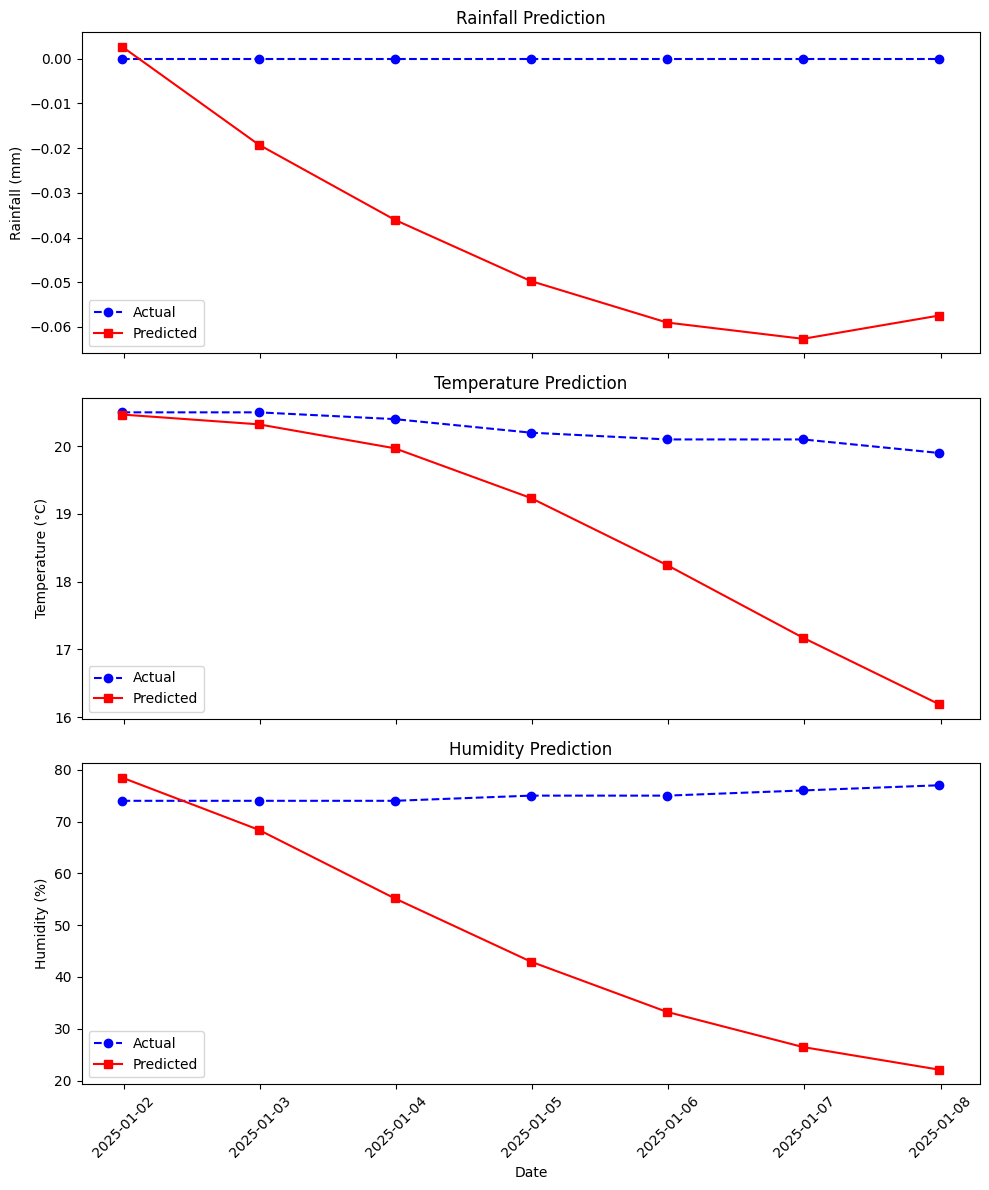

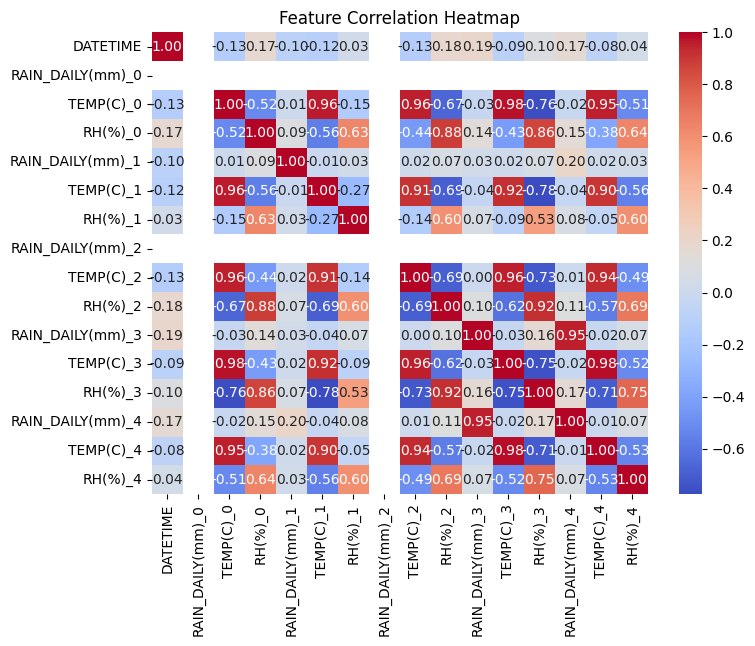

KeyError: 'loss'

<Figure size 800x500 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a date range for the next 7 days
predicted_dates = pd.date_range(start=df['DATETIME'].iloc[-1], periods=8, freq='D')[1:]

# Extract actual data for comparison (last 7 days before prediction)
actual_values = df[["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"]].values[-7:]

# Convert predicted values to a DataFrame for easy plotting
predicted_df = pd.DataFrame(real_predictions, columns=["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"], index=predicted_dates)

# Convert actual values to a DataFrame for easy plotting
actual_df = pd.DataFrame(actual_values, columns=["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"], index=predicted_dates)

### 1️⃣ Plot Actual vs Predicted for Rainfall, Temperature, and Humidity ###
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Rainfall Plot
axes[0].plot(actual_df.index, actual_df["RAIN_DAILY(mm)_0"], marker='o', label="Actual", color='blue', linestyle='dashed')
axes[0].plot(predicted_df.index, predicted_df["RAIN_DAILY(mm)_0"], marker='s', label="Predicted", color='red')
axes[0].set_title("Rainfall Prediction")
axes[0].set_ylabel("Rainfall (mm)")
axes[0].legend()

# Temperature Plot
axes[1].plot(actual_df.index, actual_df["TEMP(C)_0"], marker='o', label="Actual", color='blue', linestyle='dashed')
axes[1].plot(predicted_df.index, predicted_df["TEMP(C)_0"], marker='s', label="Predicted", color='red')
axes[1].set_title("Temperature Prediction")
axes[1].set_ylabel("Temperature (°C)")
axes[1].legend()

# Humidity Plot
axes[2].plot(actual_df.index, actual_df["RH(%)_0"], marker='o', label="Actual", color='blue', linestyle='dashed')
axes[2].plot(predicted_df.index, predicted_df["RH(%)_0"], marker='s', label="Predicted", color='red')
axes[2].set_title("Humidity Prediction")
axes[2].set_ylabel("Humidity (%)")
axes[2].legend()

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2️⃣ Feature Correlation Heatmap ###
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### 3️⃣ Model Training Loss Plot ###
plt.figure(figsize=(8, 5))
plt.plot(model.history.history['loss'], label='Training Loss', color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

### 4️⃣ Predicted Trends Over 7 Days ###
plt.figure(figsize=(10, 5))
for col in predicted_df.columns:
    plt.plot(predicted_df.index, predicted_df[col], marker='o', linestyle='-', label=col)
plt.xlabel("Date")
plt.ylabel("Predicted Values")
plt.title("Weather Parameter Predictions for Next 7 Days")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Upload Targeted Station CSV
Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 0.0977
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.0052
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0037
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0030
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0026
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0023
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0021
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 0.0018
Epoch 9/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - loss: 0.0020
Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - loss: 0.0015
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 0.0017
Epoch 12/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - loss: 0.0017
Epoch 13/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - loss: 0.0014
Epoch 14/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - loss: 0.0015
Epoch 15/20
93/

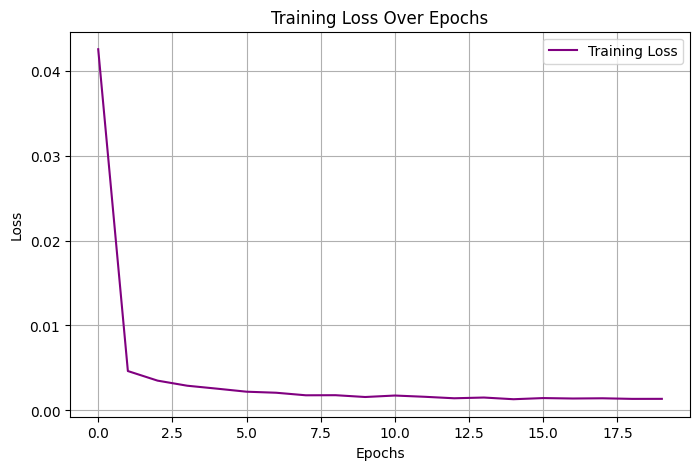

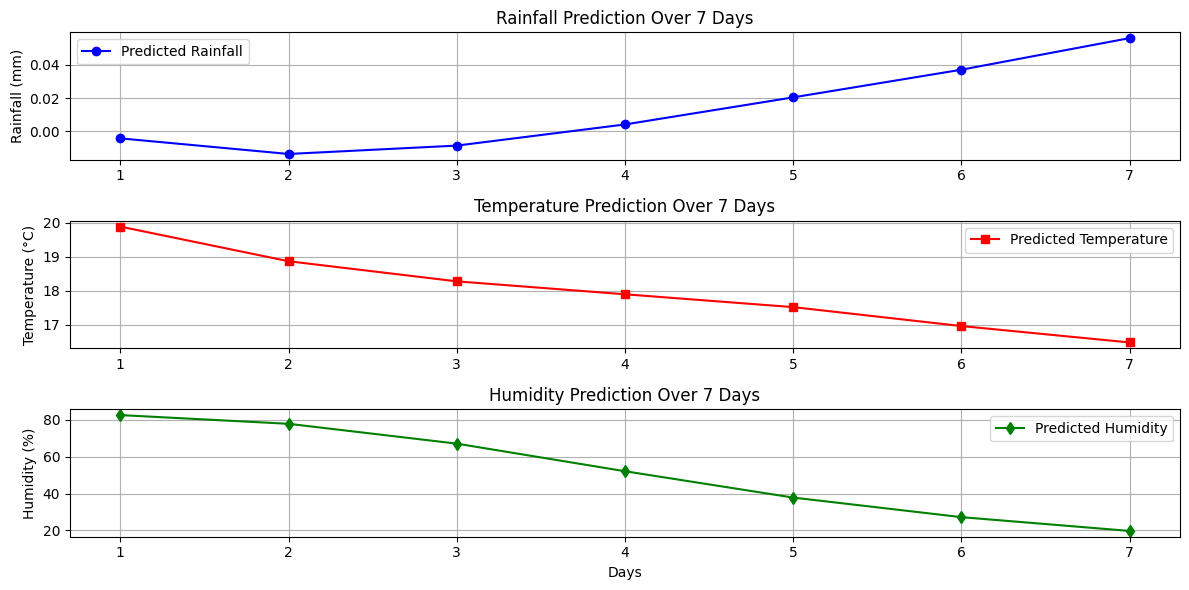

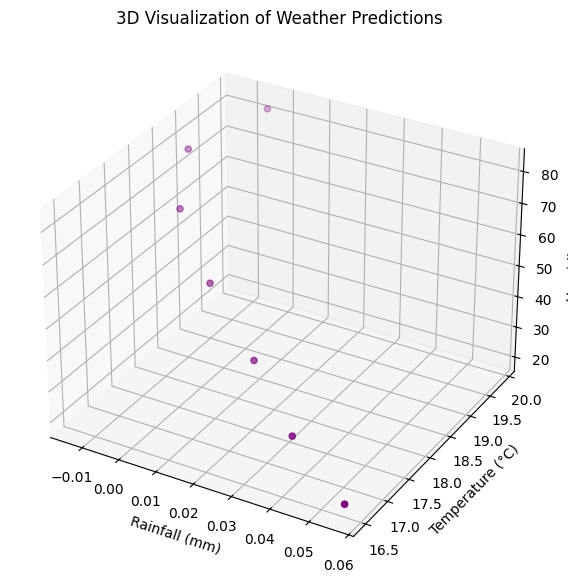

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Upload Targeted Station CSV
print("Upload Targeted Station CSV")
Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
df = pd.read_csv(target_filename)

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in df.columns:
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df = df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Forward-fill NaN values
df.ffill(inplace=True)

# Identify input and output columns
output_cols = ["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"]
input_cols = [col for col in df.columns if col not in output_cols and col != 'DATETIME']

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(df[input_cols].values)  # Inputs
y = scaler_y.fit_transform(df[output_cols].values)  # Outputs

# Function to create sequences for RNN
def create_sequences(X, y, time_steps=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 7  # Using 7 past days to predict
X_train, y_train = create_sequences(X, y, time_steps)

# Define LSTM Model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(3)  # Three output features: Rainfall, Temperature, Humidity
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model and store history for visualization
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict next 7 days recursively
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])
predicted_scaled = []

for _ in range(7):
    pred = model.predict(test_input)[0]  # Get 3-feature prediction
    predicted_scaled.append(pred)
    
    # Shift input and add predicted values
    test_input = np.roll(test_input, shift=-1, axis=1)
    
    # Extract previous input features from the last time step
    last_known_features = test_input[0, -1, :-3]  # Extract all features except last 3 output ones
    
    # Transform prediction and append to maintain correct feature shape
    predicted_features = scaler_y.inverse_transform(pred.reshape(1, -1)).flatten()  # Convert back to real values
    
    # Re-normalize the concatenated input for consistency
    new_input_row = np.hstack((last_known_features, predicted_features))  # Combine known inputs and predicted outputs
    test_input[0, -1, :] = scaler_x.transform(new_input_row.reshape(1, -1))  # Ensure correct transformation

# Convert predictions back to real values
real_predictions = scaler_y.inverse_transform(np.array(predicted_scaled))

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

### 🌟 Visualization ###

# 1️⃣ **Training Loss Plot**
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ **Actual vs. Predicted Weather Variables (Rainfall, Temperature, Humidity)**
days = np.arange(1, 8)

plt.figure(figsize=(12, 6))

# Rainfall Plot
plt.subplot(3, 1, 1)
plt.plot(days, real_predictions[:, 0], marker='o', label="Predicted Rainfall", color='blue')
plt.ylabel("Rainfall (mm)")
plt.title("Rainfall Prediction Over 7 Days")
plt.grid(True)
plt.legend()

# Temperature Plot
plt.subplot(3, 1, 2)
plt.plot(days, real_predictions[:, 1], marker='s', label="Predicted Temperature", color='red')
plt.ylabel("Temperature (°C)")
plt.title("Temperature Prediction Over 7 Days")
plt.grid(True)
plt.legend()

# Humidity Plot
plt.subplot(3, 1, 3)
plt.plot(days, real_predictions[:, 2], marker='d', label="Predicted Humidity", color='green')
plt.xlabel("Days")
plt.ylabel("Humidity (%)")
plt.title("Humidity Prediction Over 7 Days")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 3️⃣ **3D Visualization of Predicted Data**
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_predictions[:, 0], real_predictions[:, 1], real_predictions[:, 2], color='purple', marker='o')
ax.set_xlabel("Rainfall (mm)")
ax.set_ylabel("Temperature (°C)")
ax.set_zlabel("Humidity (%)")
ax.set_title("3D Visualization of Weather Predictions")
plt.show()

Upload Targeted Station CSV


2025-03-16 15:42:28.504 Python[7240:122349] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-16 15:42:28.904 Python[7240:122349] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
2025-03-16 15:42:47.441537: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-16 15:42:47.441695: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-16 15:42:47.441699: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-16 15:42:47.441878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-16 15:42:47.441889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevic

Epoch 1/20


2025-03-16 15:42:48.164099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 0.0488
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - loss: 0.0036
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 0.0025
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0022
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0016
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.0019
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0014
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.0014
Epoch 9/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - loss: 0.0012
Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - loss: 0.0013
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - loss: 0.0012
Epoch 12/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 0.0012
Epoch 13/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 0.0012
Epoch 14/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - loss: 0.0012
Epoch 15/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step 

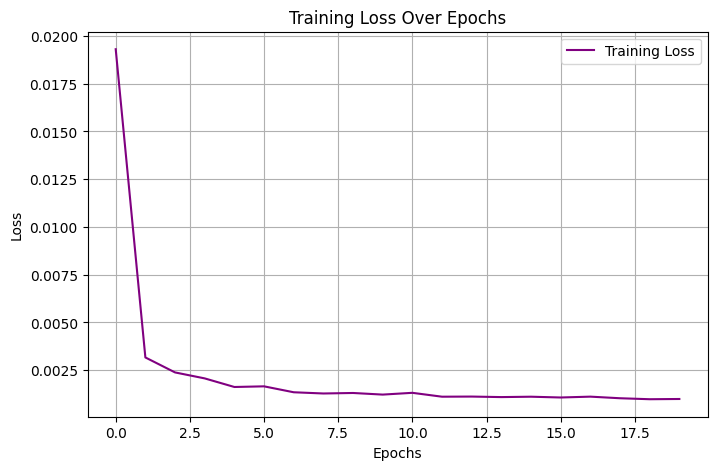

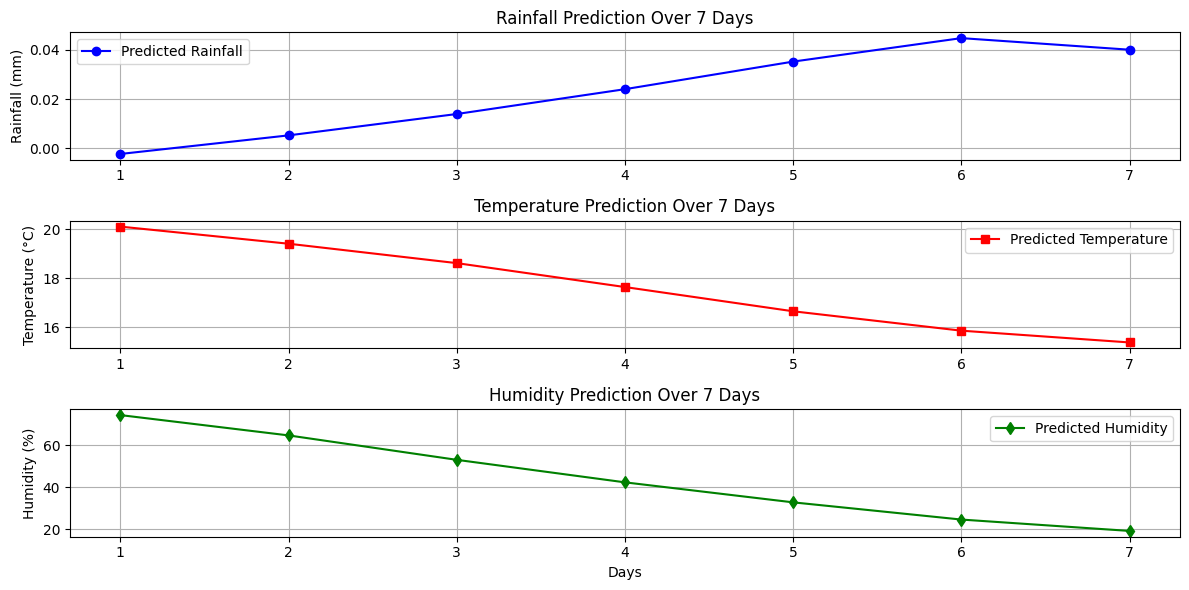

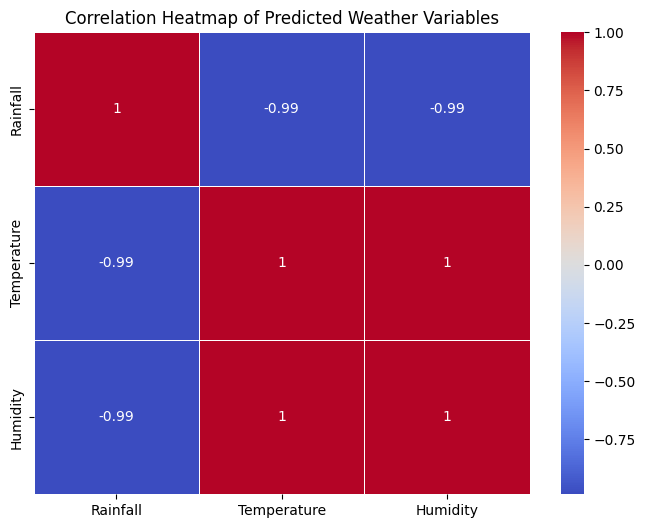

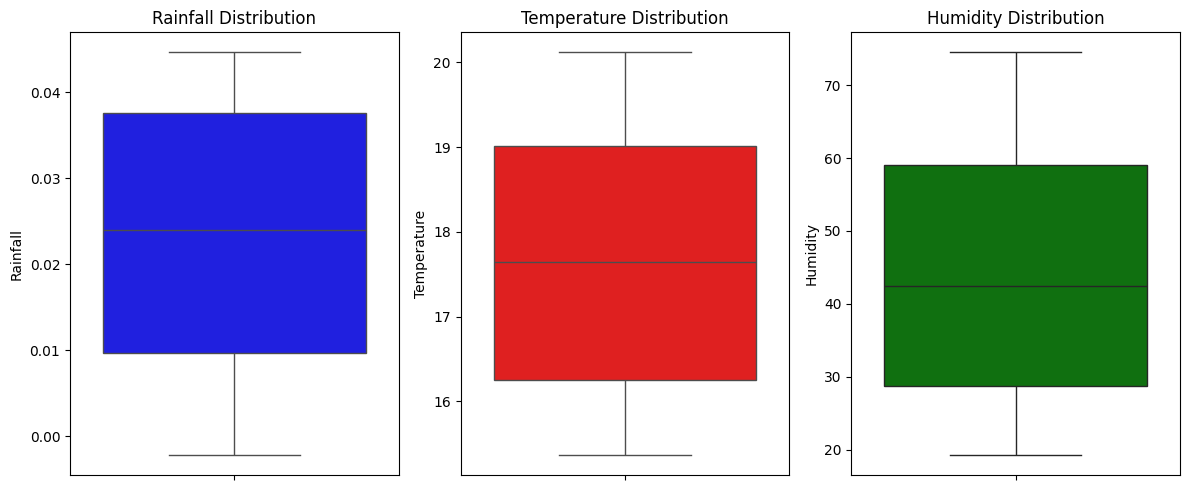

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Upload Targeted Station CSV
print("Upload Targeted Station CSV")
Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
df = pd.read_csv(target_filename)

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in df.columns:
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df = df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Forward-fill NaN values
df.ffill(inplace=True)

# Identify input and output columns
output_cols = ["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"]
input_cols = [col for col in df.columns if col not in output_cols and col != 'DATETIME']

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(df[input_cols].values)  # Inputs
y = scaler_y.fit_transform(df[output_cols].values)  # Outputs

# Function to create sequences for RNN
def create_sequences(X, y, time_steps=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 7  # Using 7 past days to predict
X_train, y_train = create_sequences(X, y, time_steps)

# Define LSTM Model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(3)  # Three output features: Rainfall, Temperature, Humidity
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model and store history for visualization
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict next 7 days recursively
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])
predicted_scaled = []

for _ in range(7):
    pred = model.predict(test_input)[0]  # Get 3-feature prediction
    predicted_scaled.append(pred)
    
    # Shift input and add predicted values
    test_input = np.roll(test_input, shift=-1, axis=1)
    
    # Extract previous input features from the last time step
    last_known_features = test_input[0, -1, :-3]  # Extract all features except last 3 output ones
    
    # Transform prediction and append to maintain correct feature shape
    predicted_features = scaler_y.inverse_transform(pred.reshape(1, -1)).flatten()  # Convert back to real values
    
    # Re-normalize the concatenated input for consistency
    new_input_row = np.hstack((last_known_features, predicted_features))  # Combine known inputs and predicted outputs
    test_input[0, -1, :] = scaler_x.transform(new_input_row.reshape(1, -1))  # Ensure correct transformation

# Convert predictions back to real values
real_predictions = scaler_y.inverse_transform(np.array(predicted_scaled))

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

### 🌟 Visualization ###

# 1️⃣ **Training Loss Plot**
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ **Actual vs. Predicted Weather Variables (Rainfall, Temperature, Humidity)**
days = np.arange(1, 8)

plt.figure(figsize=(12, 6))

# Rainfall Plot
plt.subplot(3, 1, 1)
plt.plot(days, real_predictions[:, 0], marker='o', label="Predicted Rainfall", color='blue')
plt.ylabel("Rainfall (mm)")
plt.title("Rainfall Prediction Over 7 Days")
plt.grid(True)
plt.legend()

# Temperature Plot
plt.subplot(3, 1, 2)
plt.plot(days, real_predictions[:, 1], marker='s', label="Predicted Temperature", color='red')
plt.ylabel("Temperature (°C)")
plt.title("Temperature Prediction Over 7 Days")
plt.grid(True)
plt.legend()

# Humidity Plot
plt.subplot(3, 1, 3)
plt.plot(days, real_predictions[:, 2], marker='d', label="Predicted Humidity", color='green')
plt.xlabel("Days")
plt.ylabel("Humidity (%)")
plt.title("Humidity Prediction Over 7 Days")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 3️⃣ **Correlation Heatmap**
df_predicted = pd.DataFrame(real_predictions, columns=["Rainfall", "Temperature", "Humidity"])
plt.figure(figsize=(8, 6))
sns.heatmap(df_predicted.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Predicted Weather Variables")
plt.show()

# 4️⃣ **Boxplots for Distribution Analysis**
plt.figure(figsize=(12, 5))

# Rainfall Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(y=df_predicted["Rainfall"], color='blue')
plt.title("Rainfall Distribution")

# Temperature Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=df_predicted["Temperature"], color='red')
plt.title("Temperature Distribution")

# Humidity Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=df_predicted["Humidity"], color='green')
plt.title("Humidity Distribution")

plt.tight_layout()
plt.show()

Upload Targeted Station CSV


2025-03-18 12:09:50.649 Python[3721:123012] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - loss: 0.0380
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.0029
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0026
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.0020
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0015
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 0.0015
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0014
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0013
Epoch 9/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0012
Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0011
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.0012
Epoch 12/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.0011
Epoch 13/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.0011
Epoch 14/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 0.0011
Epoch 15/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 

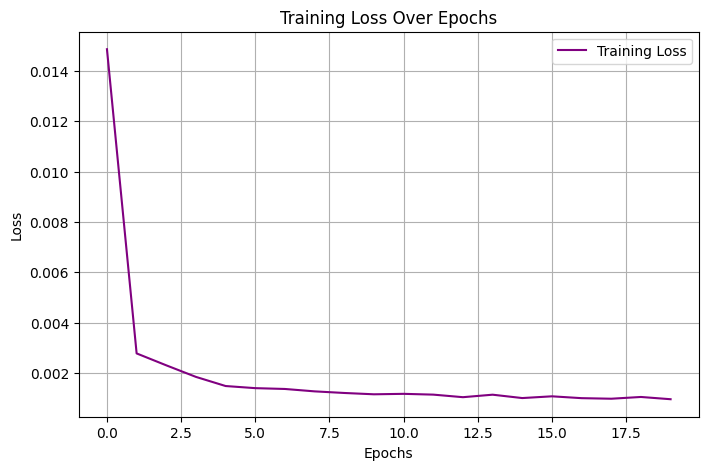

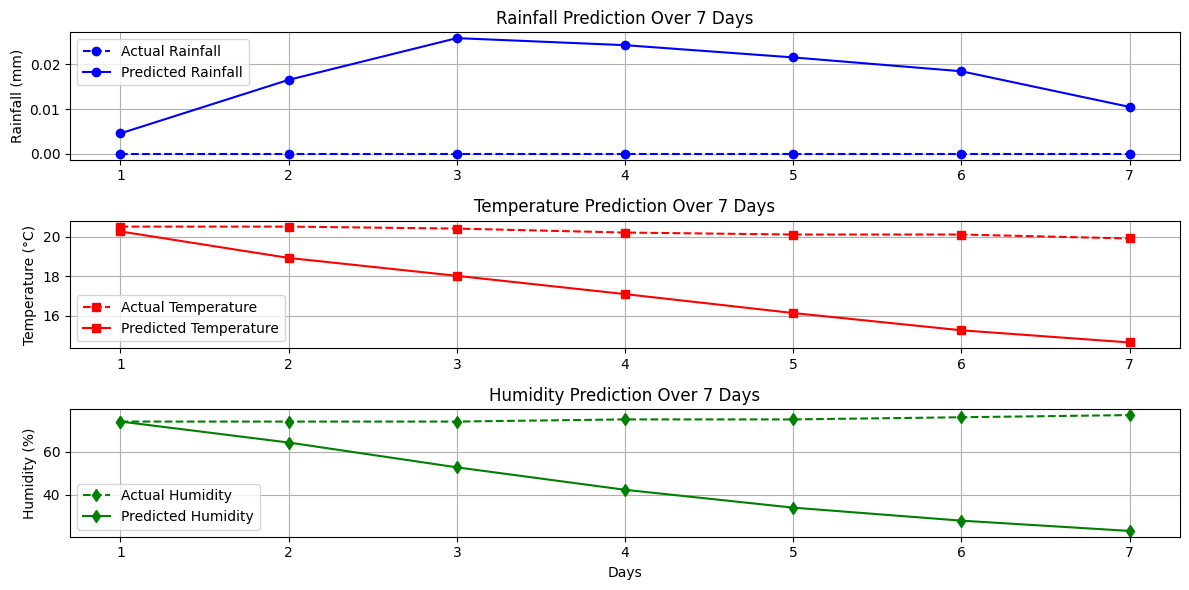

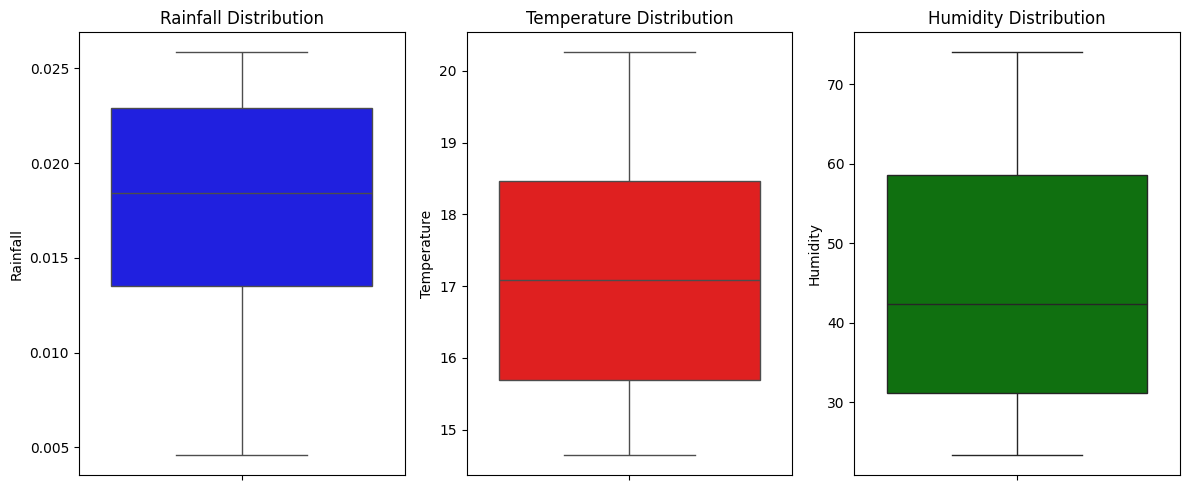

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Upload Targeted Station CSV
print("Upload Targeted Station CSV")
Tk().withdraw()
target_filename = askopenfilename(title="Select Targeted Station CSV")
df = pd.read_csv(target_filename)

# Convert DATETIME column to datetime format and sort
if 'DATETIME' in df.columns:
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df = df.sort_values(by='DATETIME')
else:
    raise ValueError("DATETIME column not found in the dataset")

# Forward-fill NaN values
df.ffill(inplace=True)

# Identify input and output columns
output_cols = ["RAIN_DAILY(mm)_0", "TEMP(C)_0", "RH(%)_0"]
input_cols = [col for col in df.columns if col not in output_cols and col != 'DATETIME']

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(df[input_cols].values)  # Inputs
y = scaler_y.fit_transform(df[output_cols].values)  # Outputs

# Function to create sequences for RNN
def create_sequences(X, y, time_steps=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 7  # Using 7 past days to predict
X_train, y_train = create_sequences(X, y, time_steps)

# Define LSTM Model
model = Sequential([
    Input(shape=(time_steps, X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(3)  # Three output features: Rainfall, Temperature, Humidity
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Train model and store history for visualization
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict next 7 days recursively
test_input = X_train[-1].reshape(1, time_steps, X_train.shape[2])
predicted_scaled = []

for _ in range(7):
    pred = model.predict(test_input)[0]  # Get 3-feature prediction
    predicted_scaled.append(pred)
    
    # Shift input and add predicted values
    test_input = np.roll(test_input, shift=-1, axis=1)
    
    # Extract previous input features from the last time step
    last_known_features = test_input[0, -1, :-3]  # Extract all features except last 3 output ones
    
    # Transform prediction and append to maintain correct feature shape
    predicted_features = scaler_y.inverse_transform(pred.reshape(1, -1)).flatten()  # Convert back to real values
    
    # Re-normalize the concatenated input for consistency
    new_input_row = np.hstack((last_known_features, predicted_features))  # Combine known inputs and predicted outputs
    test_input[0, -1, :] = scaler_x.transform(new_input_row.reshape(1, -1))  # Ensure correct transformation

# Convert predictions back to real values
real_predictions = scaler_y.inverse_transform(np.array(predicted_scaled))

# Display Predictions
print("\nPredicted Weather for Next 7 Days (Real Values):")
print(real_predictions)

### 🌟 Model Evaluation ###
# Take the last 7 actual values from the dataset as the ground truth
y_true = scaler_y.inverse_transform(y[-7:])  # Last 7 days of actual values

# Compute metrics for each feature
metrics = {}
for i, feature in enumerate(["Rainfall", "Temperature", "Humidity"]):
    mae = mean_absolute_error(y_true[:, i], real_predictions[:, i])
    mse = mean_squared_error(y_true[:, i], real_predictions[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true[:, i], real_predictions[:, i])
    metrics[feature] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

# Print Model Evaluation Metrics
print("\n📊 Model Performance Metrics:")
for feature, scores in metrics.items():
    print(f"\n🔹 {feature}:")
    print(f"   MAE  : {scores['MAE']:.3f}")
    print(f"   MSE  : {scores['MSE']:.3f}")
    print(f"   RMSE : {scores['RMSE']:.3f}")
    print(f"   R²   : {scores['R²']:.3f}")

### 🌟 Visualization ###

# 1️⃣ **Training Loss Plot**
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ **Actual vs. Predicted Weather Variables (Rainfall, Temperature, Humidity)**
days = np.arange(1, 8)

plt.figure(figsize=(12, 6))

# Rainfall Plot
plt.subplot(3, 1, 1)
plt.plot(days, y_true[:, 0], marker='o', label="Actual Rainfall", color='blue', linestyle="dashed")
plt.plot(days, real_predictions[:, 0], marker='o', label="Predicted Rainfall", color='blue')
plt.ylabel("Rainfall (mm)")
plt.title("Rainfall Prediction Over 7 Days")
plt.grid(True)
plt.legend()

# Temperature Plot
plt.subplot(3, 1, 2)
plt.plot(days, y_true[:, 1], marker='s', label="Actual Temperature", color='red', linestyle="dashed")
plt.plot(days, real_predictions[:, 1], marker='s', label="Predicted Temperature", color='red')
plt.ylabel("Temperature (°C)")
plt.title("Temperature Prediction Over 7 Days")
plt.grid(True)
plt.legend()

# Humidity Plot
plt.subplot(3, 1, 3)
plt.plot(days, y_true[:, 2], marker='d', label="Actual Humidity", color='green', linestyle="dashed")
plt.plot(days, real_predictions[:, 2], marker='d', label="Predicted Humidity", color='green')
plt.xlabel("Days")
plt.ylabel("Humidity (%)")
plt.title("Humidity Prediction Over 7 Days")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 3️⃣ **Boxplots for Distribution Analysis**
df_predicted = pd.DataFrame(real_predictions, columns=["Rainfall", "Temperature", "Humidity"])

plt.figure(figsize=(12, 5))
for i, feature in enumerate(df_predicted.columns):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df_predicted[feature], color=['blue', 'red', 'green'][i])
    plt.title(f"{feature} Distribution")

plt.tight_layout()
plt.show()